Aim : Reproduce figure 2 and 3 from https://pubs.aip.org/aip/app/article/5/12/121301/123226/Generation-of-280-THz-spanning-near-ultraviolet

First, create waveguide geometry. Run the fem solver to get the effective refractive index and effective area of the waveguide.

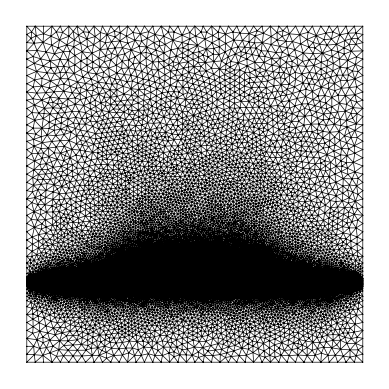

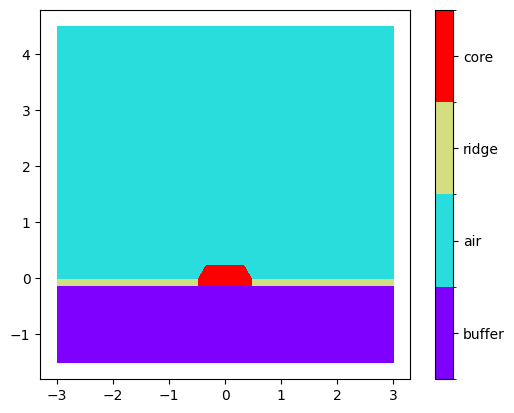

In [4]:
import math

from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from refractive_index import n_SiO2, n_Air, n_LNOI
from collections import OrderedDict
import scipy
import numpy as np
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Polygon

wavelength_range = [310, 1500]
wavelegnth_step = 20  # 50nm steps

n_core = n_LNOI
n_ridge = n_LNOI
n_buffer = n_SiO2
n_air = n_Air

# waveguide parameters
width = 0.7  # um
total_height = 0.4  # um
ridge_height = 0.25
box_height = 3

triangle_height = 0.25
triangle_width = triangle_height/ math.tan(60 * math.pi /180)


# Construct waveguide geometry
core_trapiz = Polygon([(width/2 + triangle_width,0 ),(-width/2 - triangle_width, 0),(-width/2, triangle_height) , (+width/2, triangle_height)])
core_box = shapely.geometry.box(-(width/2 + triangle_width), -0.15, (width/2 + triangle_width), 0)
core = unary_union([core_trapiz, core_box])

ridge = shapely.geometry.box(-box_height, -0.15,box_height , 0)

buffer = shapely.geometry.box(-box_height,-box_height/2,box_height,-0.15)
air = shapely.geometry.box(-box_height,-box_height/2,box_height,box_height*1.5)


polygon = OrderedDict(
    core = core,
    ridge = ridge,
    buffer = buffer,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.01, "distance": 0.1},
                   ridge ={"resolution": 0.01, "distance": 0.1},
                   buffer={"resolution": 0.15, "distance": 0.5},
                   air={"resolution": 0.15, "distance": 0.5})

n_dict = {"core": n_core, "ridge": n_ridge, "buffer": n_buffer, "air": n_air}

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

Plot the effective refractive index and calculate the GVD and dispersion operator

Propagate laser to the waveguide 

In [ ]:

from PyNLO.PyNLO import pynlo
from scipy.constants import pi, c
"""
We start by initializing a hyperbolic secant pulse using one of the built-in
pulse shapes of the `Pulse` class. The first few parameters constrain the
frequency grid, the number of points and the frequency range, while the last
three set the initial pulse properties, its center frequency, pulse energy, and
pulse width.

"""
n_points = 2**14
f_min = c/1400e-9   # c / 1400 nm
f_max = c/475e-9    # c / 475 nm

f0 = c/835e-9       # c / 835 nm
e_p = 13e-12       # energy per pulse in joules
t_fwhm = 220e-15  * np.sqrt(2)   # fwhm in second (for sech, fwhm = 1.76 * pulse duration )

pulse = pynlo.light.Pulse.Sech(n_points, f_min, f_max, f0, e_p, t_fwhm)